In [152]:
%load_ext autoreload
%autoreload 2

# ignore imputation warnings from pymc
# ImputationWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
import warnings
from pymc import ImputationWarning

warnings.filterwarnings("ignore", category=ImputationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [180]:
from birdcall_distribution.data import prepare_dataframe
import pandas as pd

taxonomy_df = pd.read_csv(
    "https://storage.googleapis.com/birdclef-eda-f22/data/raw/birdclef-2022/eBird_Taxonomy_v2021.csv"
)
taxonomy_df.columns = taxonomy_df.columns.str.lower()
species_mapper = taxonomy_df.set_index("species_code")["primary_com_name"].to_dict()

prep_df, W = prepare_dataframe(
    "../data/ee_v3_western_us_2.parquet",
    "../data/raw/birdclef-2022/train_metadata.csv",
    n_species=3,
)
prep_df.shape

(384, 33)

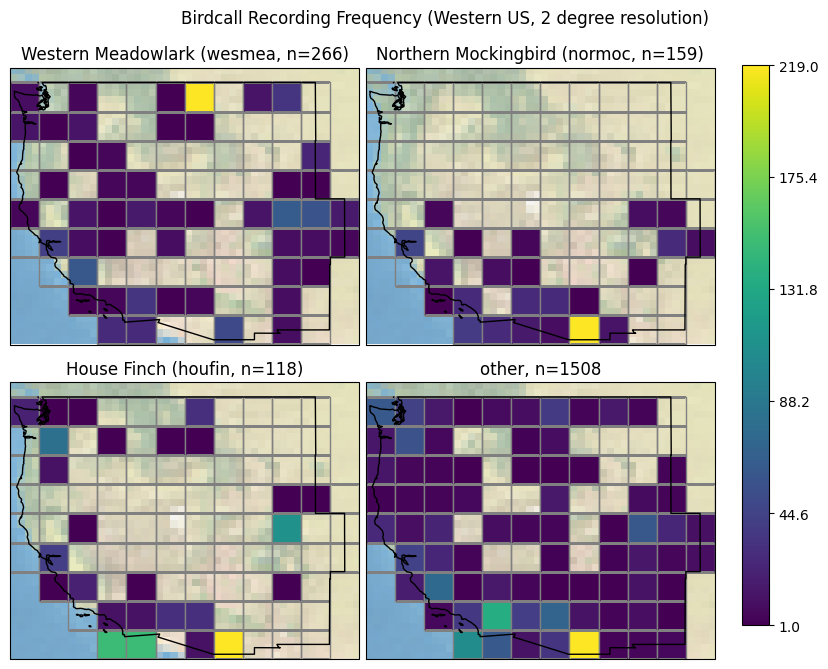

In [181]:
import matplotlib.pyplot as plt
from birdcall_distribution.plot import plot_species_subplot
import numpy as np

# grid size
grid_size = prep_df.grid_size.values[0]

# sorted list of records
species = list(
    prep_df[prep_df.primary_label != "other"]
    .groupby("primary_label")
    .sum(numeric_only=True)
    .y.sort_values(ascending=False)
    .index
)
plot_species_subplot(
    prep_df,
    species + ["other"],
    prop="y",
    subtitle=f"Western US, {grid_size} degree resolution",
    species_mapper=species_mapper,
)
plt.show()

In [155]:
from birdcall_distribution import model
import pymc as pm
import arviz as az

m1 = model.make_varying_intercept_varying_covariate_car_model(prep_df, W)
with m1:
    trace1 = pm.sample(2500, tune=1000, cores=16, target_accept=0.9)

Multiprocess sampling (16 chains in 16 jobs)
CompoundStep
>NUTS: [alpha, sigma_phi, phi, intercept_bar, intercept_sigma, intercept, betas_bar, betas_sigma, betas]
>Metropolis: [y_missing]


Sampling 16 chains for 1_000 tune and 2_500 draw iterations (16_000 + 40_000 draws total) took 485 seconds.


In [158]:
with m1:
    # posterior predictive
    ppc1 = pm.sample_posterior_predictive(trace1)

Sampling: [y_observed]


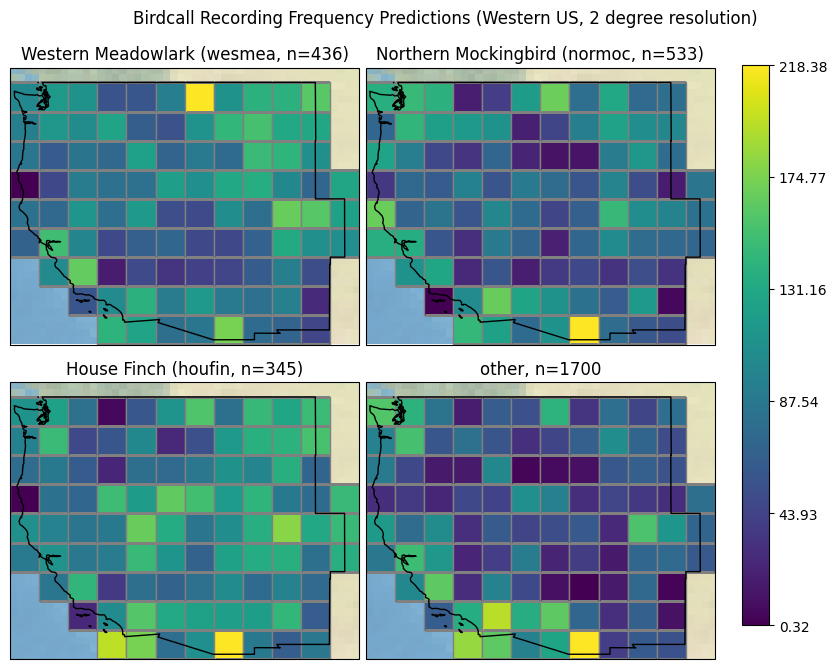

In [159]:
from birdcall_distribution.plot import plot_ppc_species_subplot

plot_ppc_species_subplot(
    prep_df,
    ppc1,
    species + ["other"],
    prop="pred",
    species_mapper=species_mapper,
    subtitle=f"Western US, {grid_size} degree resolution",
)
plt.show()

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

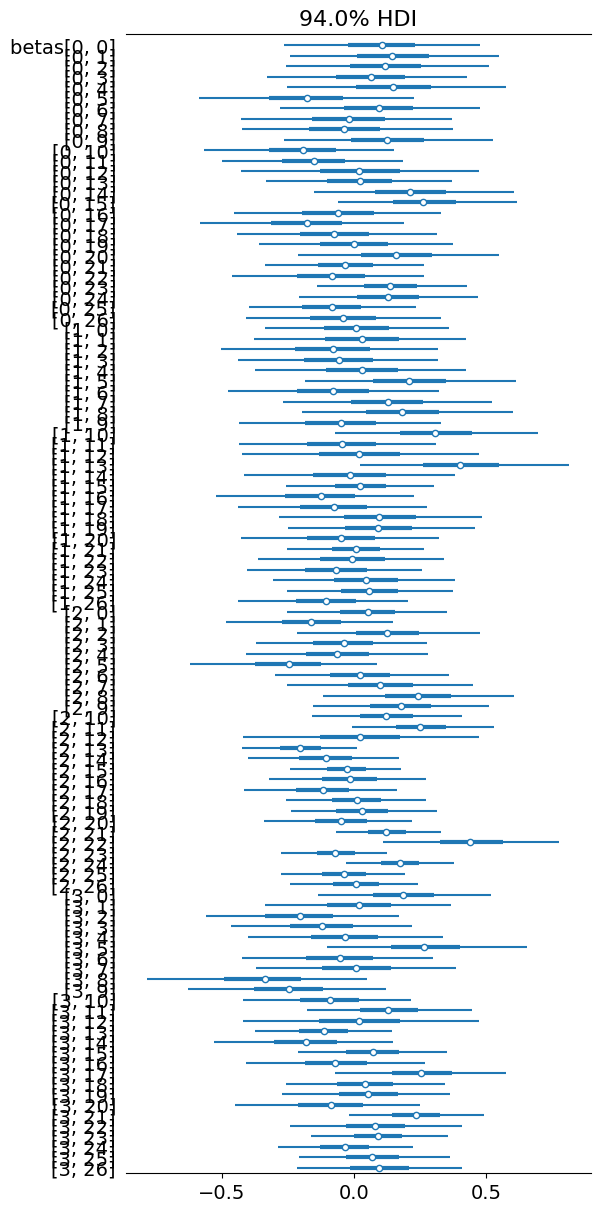

In [160]:
az.plot_forest(trace1, var_names=["betas"], combined=True)

In [161]:
betas = az.summary(trace1, var_names=["betas"])
betas

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"betas[0, 0]",0.108,0.196,-0.265,0.477,0.013,0.009,240.0,400.0,1.04
"betas[0, 1]",0.150,0.209,-0.241,0.548,0.011,0.008,388.0,1079.0,1.03
"betas[0, 2]",0.121,0.203,-0.255,0.513,0.006,0.004,1052.0,5447.0,1.01
"betas[0, 3]",0.062,0.201,-0.329,0.429,0.005,0.003,1725.0,5429.0,1.01
"betas[0, 4]",0.152,0.219,-0.254,0.575,0.009,0.006,604.0,1929.0,1.02
...,...,...,...,...,...,...,...,...,...
"betas[3, 22]",0.084,0.172,-0.242,0.409,0.005,0.004,1040.0,2097.0,1.01
"betas[3, 23]",0.091,0.137,-0.161,0.355,0.004,0.002,1530.0,4174.0,1.01
"betas[3, 24]",-0.036,0.136,-0.289,0.223,0.007,0.005,384.0,1766.0,1.03
"betas[3, 25]",0.073,0.152,-0.209,0.362,0.007,0.005,414.0,2999.0,1.03


In [162]:
from birdcall_distribution.model import _scaled_data

scaled_df = _scaled_data(prep_df)
scaled_df.columns

Index(['population_density', 'elevation_p5', 'elevation_p50', 'elevation_p95',
       'LST_Day_1km_p5', 'LST_Day_1km_p50', 'LST_Day_1km_p95',
       'LST_Night_1km_p5', 'LST_Night_1km_p50', 'LST_Night_1km_p95',
       'land_cover_01', 'land_cover_02', 'land_cover_03', 'land_cover_04',
       'land_cover_05', 'land_cover_06', 'land_cover_07', 'land_cover_08',
       'land_cover_09', 'land_cover_10', 'land_cover_11', 'land_cover_12',
       'land_cover_13', 'land_cover_14', 'land_cover_15', 'land_cover_16',
       'land_cover_17'],
      dtype='object')

In [163]:
# find all betas where interval is entirely positive or negative
sig_betas = betas[
    ((betas["hdi_3%"] > 0) & (betas["hdi_97%"] > 0))
    | ((betas["hdi_3%"] < 0) & (betas["hdi_97%"] < 0))
]

In [164]:
prep_df.primary_label.astype("category").cat.categories

Index(['houfin', 'normoc', 'other', 'wesmea'], dtype='object')

In [165]:
sig_betas.reset_index()["index"]

0    betas[1, 13]
1    betas[2, 22]
Name: index, dtype: object

In [166]:
from birdcall_distribution.geo import get_modis_land_cover_name
import re


def maybe_landcover(name):
    try:
        return f"landcover {get_modis_land_cover_name(name)}".lower().replace(" ", "_")
    except Exception:
        return name


def replace_indices(name, species_list, covariate_list):
    # extract the indexes from the name e.g. [1, 2]
    [(species, covariate)] = list(re.findall(r"\[(\d+), (\d+)\]", name))
    species = species_list[int(species)]
    covariate = covariate_list[int(covariate)]
    return name.split("[")[0] + f"[{species}, {covariate}]"


species = prep_df.primary_label.astype("category").cat.categories
columns = [maybe_landcover(c) for c in scaled_df.columns]

sig_betas.index = sig_betas.reset_index()["index"].apply(
    lambda x: replace_indices(x, species, columns)
)
sig_betas

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
index,,,,,,,,,
"betas[normoc, landcover_deciduous_broadleaf_forest]",0.410,0.211,0.025,0.815,0.026,0.019,68.0,157.0,1.16
"betas[other, landcover_urban_and_built-up]",0.449,0.179,0.109,0.778,0.013,0.009,197.0,741.0,1.05


In [167]:
print(sig_betas.iloc[:, :4].to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &   mean &     sd &  hdi\_3\% &  hdi\_97\% \\
index                                              &        &        &         &          \\
\midrule
betas[normoc, landcover\_deciduous\_broadleaf\_for... &  0.410 &  0.211 &   0.025 &    0.815 \\
betas[other, landcover\_urban\_and\_built-up]         &  0.449 &  0.179 &   0.109 &    0.778 \\
\bottomrule
\end{tabular}



C:\Users\acmiy\AppData\Local\Temp\ipykernel_20532\53194228.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(sig_betas.iloc[:, :4].to_latex())


## larger number of species

In [175]:
prep_df, W = prepare_dataframe(
    "../data/ee_v3_western_us_2.parquet",
    "../data/raw/birdclef-2022/train_metadata.csv",
    n_species=None,
)

# find counts of all species
species_counts = prep_df.groupby("primary_label").count().y
species_counts.sort_values(ascending=False)[:16]

primary_label
wesmea     49
towsol     29
houfin     26
normoc     23
calqua     20
belkin1    20
grbher3    20
sora       20
pibgre     19
sposan     18
moudov     18
gadwal     15
gamqua     14
bknsti     14
cangoo     13
snogoo     13
Name: y, dtype: int64

In [183]:
prep_df, W = prepare_dataframe(
    "../data/ee_v3_western_us_2.parquet",
    "../data/raw/birdclef-2022/train_metadata.csv",
    n_species=15,
)
prep_df.shape

(1536, 33)

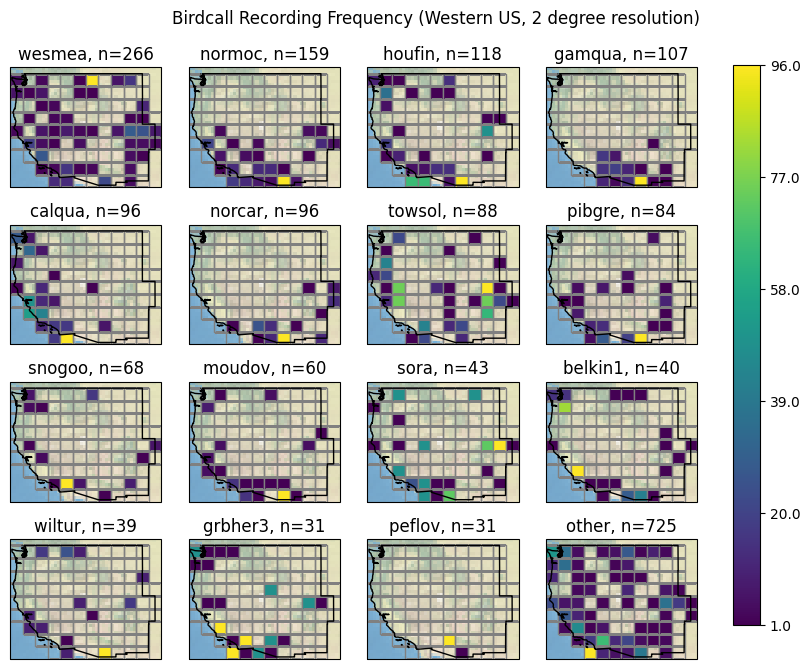

In [184]:
# grid size
grid_size = prep_df.grid_size.values[0]

# sorted list of records
species = list(
    prep_df[prep_df.primary_label != "other"]
    .groupby("primary_label")
    .sum(numeric_only=True)
    .y.sort_values(ascending=False)
    .index
)
plot_species_subplot(
    prep_df,
    species + ["other"],
    prop="y",
    subtitle=f"Western US, {grid_size} degree resolution",
    shape=(4, 4),
)
plt.show()

In [185]:
m2 = model.make_varying_intercept_varying_covariate_car_model(prep_df, W)
with m2:
    trace2 = pm.sample(2500, tune=1000, cores=16, target_accept=0.9)

Multiprocess sampling (16 chains in 16 jobs)
CompoundStep
>NUTS: [alpha, sigma_phi, phi, intercept_bar, intercept_sigma, intercept, betas_bar, betas_sigma, betas]
>Metropolis: [y_missing]


Sampling 16 chains for 1_000 tune and 2_500 draw iterations (16_000 + 40_000 draws total) took 2310 seconds.


In [188]:
with m2:
    # posterior predictive
    ppc2 = pm.sample_posterior_predictive(trace2)

Sampling: [y_observed]


In [201]:
# pickle this data to disk
import pickle

with open("../data/2022-02-12-02-ppc2.pkl", "wb") as f:
    pickle.dump(ppc2, f)

In [202]:
with open("../data/2022-02-12-02-ppc2.pkl", "rb") as f:
    ppc_temp = pickle.load(f)

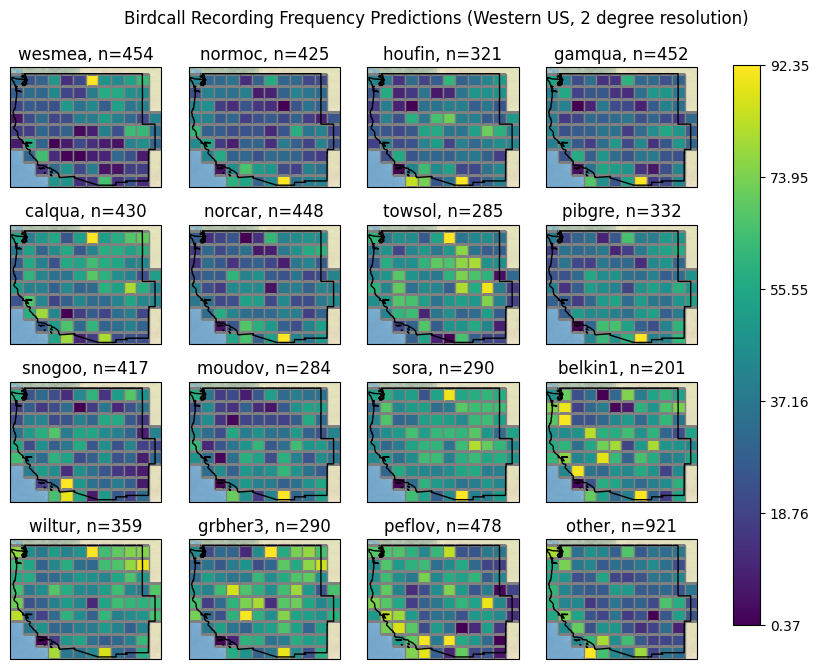

In [217]:
from birdcall_distribution.plot import plot_ppc_species_subplot

plot_ppc_species_subplot(
    prep_df,
    ppc_temp,
    species + ["other"],
    prop="pred",
    shape=(4, 4),
    subtitle=f"Western US, {grid_size} degree resolution",
)
plt.show()

In [222]:
betas = az.summary(trace2, var_names=["betas"])
sig_betas = betas[
    ((betas["hdi_3%"] > 0) & (betas["hdi_97%"] > 0))
    | ((betas["hdi_3%"] < 0) & (betas["hdi_97%"] < 0))
]

species = prep_df.primary_label.astype("category").cat.categories
columns = [maybe_landcover(c) for c in scaled_df.columns]

sig_betas.index = sig_betas.reset_index()["index"].apply(
    lambda x: replace_indices(x, species, columns)
)
sig_betas

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
index,,,,,,,,,
"betas[belkin1, landcover_cropland/natural_vegetation]",0.322,0.158,0.018,0.611,0.013,0.009,145.0,488.0,1.07
"betas[gamqua, landcover_closed_shrublands]",-0.260,0.133,-0.508,-0.008,0.009,0.007,198.0,1369.0,1.06
"betas[other, elevation_p5]",-0.278,0.149,-0.560,-0.002,0.008,0.006,323.0,953.0,1.03
"betas[other, landcover_deciduous_broadleaf_forest]",-0.206,0.103,-0.401,-0.015,0.009,0.006,138.0,572.0,1.07
"betas[other, landcover_mixed_forests]",-0.338,0.139,-0.596,-0.072,0.011,0.008,163.0,838.0,1.07
"betas[other, landcover_urban_and_built-up]",0.543,0.153,0.249,0.827,0.008,0.006,386.0,1885.0,1.03
"betas[snogoo, landcover_closed_shrublands]",0.336,0.168,0.017,0.648,0.022,0.015,59.0,168.0,1.19
"betas[snogoo, landcover_barren_or_sparsely_vegetated]",0.358,0.164,0.052,0.669,0.014,0.010,135.0,410.0,1.08
"betas[snogoo, landcover_water_bodies]",0.390,0.176,0.060,0.727,0.015,0.011,142.0,307.0,1.08


In [223]:
print(sig_betas.iloc[:, :4].to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &   mean &     sd &  hdi\_3\% &  hdi\_97\% \\
index                                              &        &        &         &          \\
\midrule
betas[belkin1, landcover\_cropland/natural\_veget... &  0.322 &  0.158 &   0.018 &    0.611 \\
betas[gamqua, landcover\_closed\_shrublands]         & -0.260 &  0.133 &  -0.508 &   -0.008 \\
betas[other, elevation\_p5]                         & -0.278 &  0.149 &  -0.560 &   -0.002 \\
betas[other, landcover\_deciduous\_broadleaf\_forest] & -0.206 &  0.103 &  -0.401 &   -0.015 \\
betas[other, landcover\_mixed\_forests]              & -0.338 &  0.139 &  -0.596 &   -0.072 \\
betas[other, landcover\_urban\_and\_built-up]         &  0.543 &  0.153 &   0.249 &    0.827 \\
betas[snogoo, landcover\_closed\_shrublands]         &  0.336 &  0.168 &   0.017 &    0.648 \\
betas[snogoo, landcover\_barren\_or\_sparsely\_vege... &  0.358 &  0.164 &   0.052 &    0.669 \\
betas[snogoo, landcover\_water\_bodies]              &

C:\Users\acmiy\AppData\Local\Temp\ipykernel_20532\53194228.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(sig_betas.iloc[:, :4].to_latex())
